In [96]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.patches import Patch

#datetime to parse dates
from datetime import datetime
from datetime import date
from datetime import time

## Analysis Plan

**Research Questions**
- Which weekdays have the highest concentration of events?
- Are some schools more likely to schedule conflicting events than others?
- Which Sports are more likely to have conflicting events?
- Weighted by number of participants, how busy are the various weeknights?

**Hypotheses**
- Most conflicts will come from sports with evening games (basketball, football, soccer).
- Mid-week days (Tuesday–Thursday) will have more conflicts than weekends.

**Key Columns for Analysis**
- `EventDate` → to explore seasonality and trends over the year
- `Weekday` → to analyze distribution of events by day
- `School` → identify which schools cause the most overlap
- `Sport` → check which sports drive scheduling conflicts


In [99]:
# Define the file path (adjust the date string to match your file)
file_path = r"C:\Users\Kaity\Desktop\SchoolActivityDays\Evenings_SANcleaned_latest.csv"

# Load the CSV into a DataFrame
SAN_df = pd.read_csv(file_path)

# Quick checks
print(SAN_df.shape)
print(SAN_df.head())

(1763, 12)
          Sport        Date    Time                 School    Weekday  \
0          Golf  2024-08-05     TBD  Riverbend High School     Monday   
1          Golf  2024-08-07     TBD  Riverbend High School  Wednesday   
2          Golf  2024-08-14  4:00pm  Riverbend High School  Wednesday   
3  Field Hockey  2024-08-14  5:00pm  Riverbend High School  Wednesday   
4          Golf  2024-08-15  4:00pm  Riverbend High School   Thursday   

    Time_dt   EventDate season_start  season_end  start_min  end_min_raw  \
0       NaN  2024-08-05   2024-07-29  2024-10-15        NaN          NaN   
1       NaN  2024-08-07   2024-07-29  2024-10-15        NaN          NaN   
2  16:00:00  2024-08-14   2024-07-29  2024-10-15      960.0          NaN   
3  17:00:00  2024-08-14   2024-08-04  2024-11-10     1020.0          NaN   
4  16:00:00  2024-08-15   2024-07-29  2024-10-15      960.0          NaN   

   end_min  
0      NaN  
1      NaN  
2   1140.0  
3   1200.0  
4   1140.0  


In [101]:
# Count events per weekday, not weighted by participant
weekday_counts = SAN_df['Weekday'].value_counts().sort_index()

print(weekday_counts)


Weekday
Friday       316
Monday       324
Saturday      30
Thursday     368
Tuesday      382
Wednesday    343
Name: count, dtype: int64


In [103]:
# Count sports on Thursday
thurs_sports = (
    SAN_df[SAN_df['Weekday'] == "Thursday"]
    ['Sport'].value_counts()
)

print("Sports on Thursday:\n", thurs_sports)

Sports on Thursday:
 Sport
Soccer               47
Basketball           45
Volleyball           43
Field Hockey         41
Softball             39
Baseball             36
Tennis               25
Football             24
Swim & Dive          19
Wrestling            17
Golf                 13
Lacrosse             10
Outdoor Track         5
Cross Country         2
Competition Cheer     1
Indoor Track          1
Name: count, dtype: int64


In [105]:
# Count sports on Friday
fri_sports = (
    SAN_df[SAN_df['Weekday'] == "Friday"]
    ['Sport'].value_counts()
)

print("Sports on Friday:\n", fri_sports)

Sports on Friday:
 Sport
Football         60
Basketball       54
Soccer           41
Baseball         35
Swim & Dive      33
Softball         32
Wrestling        19
Tennis           16
Volleyball       15
Field Hockey      5
Lacrosse          2
Cross Country     1
Outdoor Track     1
Indoor Track      1
Golf              1
Name: count, dtype: int64


In [107]:
# Filter for Lacrosse events
lax_events = SAN_df[SAN_df['Sport'].str.contains("Lacrosse", case=False, na=False)]

# Get counts of which weekdays Lacrosse events fall on
lax_by_day = lax_events['Weekday'].value_counts().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
    fill_value=0
)

print(lax_by_day)

Weekday
Monday       11
Tuesday       7
Wednesday    11
Thursday     10
Friday        2
Saturday      0
Sunday        0
Name: count, dtype: int64


In [109]:
print("Events per school:")
print(SAN_df['School'].value_counts())

Events per school:
School
Chancellor High School      692
Massaponax High School      281
Riverbend High School       272
Courtland High School       272
Spotsylvania High School    246
Name: count, dtype: int64


In [111]:
# Create a df of Average roster sizes for various high school sports for similar school sizes in virginia

avg_roster_va = {
    "Golf": 10,
    "Field Hockey": 22,
    "Football": 55,
    "Volleyball": 12,
    "Competition Cheer": 18,
    "Basketball": 12,
    "Wrestling": 24,
    "Swim & Dive": 30,
    "Lacrosse": 24,
    "Tennis": 12,
    "Softball": 14,
    "Baseball": 18,
    "Soccer": 20,
    "Outdoor Track": 60,
    "Indoor Track": 50,
    "Cross Country": 50,
}

df = SAN_df.copy()

# Add the average participants column based on the Sport value
df["Participants"] = df["Sport"].map(avg_roster_va).astype("float")

# quick check for any sports that weren't mapped
unmapped = sorted(set(df["Sport"]) - set(avg_roster_va.keys()))
if unmapped:
    print("Unmapped sports (update avg_roster_va if needed):", unmapped)

SAN_df = df

In [113]:
print(SAN_df.columns)

Index(['Sport', 'Date', 'Time', 'School', 'Weekday', 'Time_dt', 'EventDate',
       'season_start', 'season_end', 'start_min', 'end_min_raw', 'end_min',
       'Participants'],
      dtype='object')


In [115]:
# Aggregate: sum participants per weekday
# Make sure EventDate is datetime (just in case)
SAN_df['EventDate'] = pd.to_datetime(SAN_df['EventDate'], errors='coerce')

# Sum participants
busy_weeknights = (
    SAN_df.groupby('Weekday')['Participants']
    .sum()
    .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday"])  # nice order
    .reset_index()
)

print(busy_weeknights)

     Weekday  Participants
0     Monday        6680.0
1    Tuesday        7619.0
2  Wednesday        9214.0
3   Thursday        7528.0
4     Friday        7992.0


In [117]:
#Wednesday is the busiest, which I would not expect. Let's see why.

# Filter only Wednesday events
wednesday_df = SAN_df[SAN_df['Weekday'] == "Wednesday"]

# Group by sport, summing participants
wednesday_sports = (
    wednesday_df.groupby('Sport')['Participants']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

print(wednesday_sports)

                Sport  Participants
0            Football        1980.0
1       Outdoor Track        1260.0
2       Cross Country        1200.0
3              Soccer         720.0
4           Wrestling         672.0
5        Indoor Track         500.0
6            Baseball         486.0
7          Basketball         372.0
8            Softball         336.0
9        Field Hockey         308.0
10        Swim & Dive         300.0
11             Tennis         288.0
12           Lacrosse         264.0
13         Volleyball         252.0
14               Golf         240.0
15  Competition Cheer          36.0


In [119]:
#Now I want to see which days cross country events occur on
# Filter for rows where the sport contains 'Soccer'
cc_df = SAN_df[SAN_df['Sport'].str.contains("Cross Country", case=False, na=False)]

# Group by weekday, sum participants (or just counts of events)
cc_nights = (
    cc_df.groupby('Weekday')['Participants']
    .sum()
    .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday"])  # keep order
    .reset_index()
)

print(cc_nights)

     Weekday  Participants
0     Monday          50.0
1    Tuesday          50.0
2  Wednesday        1200.0
3   Thursday         100.0
4     Friday          50.0


In [121]:
#Now I want to see which days soccer events occur on
# Filter for rows where the sport contains 'Soccer'
soccer_df = SAN_df[SAN_df['Sport'].str.contains("Soccer", case=False, na=False)]

# Group by weekday, sum participants (or just counts of events)
soccer_nights = (
    soccer_df.groupby('Weekday')['Participants']
    .sum()
    .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday"])  # keep order
    .reset_index()
)

print(soccer_nights)

     Weekday  Participants
0     Monday         760.0
1    Tuesday        1040.0
2  Wednesday         720.0
3   Thursday         940.0
4     Friday         820.0


In [123]:
# --- 1) Total participants per sport ---
sport_totals = SAN_df.groupby("Sport")["Participants"].sum().sort_values()

# --- 2) Add % of total participants ---
sport_summary = sport_totals.to_frame(name="TotalParticipants")
sport_summary["PercentOfTotal"] = (
    100 * sport_summary["TotalParticipants"] / sport_summary["TotalParticipants"].sum()
)

print(sport_summary)

                   TotalParticipants  PercentOfTotal
Sport                                               
Competition Cheer              144.0        0.361382
Golf                           560.0        1.405376
Lacrosse                       984.0        2.469446
Tennis                        1296.0        3.252441
Indoor Track                  1400.0        3.513439
Cross Country                 1550.0        3.889879
Volleyball                    1824.0        4.577509
Outdoor Track                 1860.0        4.667855
Softball                      2422.0        6.078249
Wrestling                     2472.0        6.203729
Field Hockey                  2926.0        7.343087
Swim & Dive                   2940.0        7.378222
Basketball                    2964.0        7.438452
Baseball                      3150.0        7.905238
Soccer                        4280.0       10.741085
Football                      9075.0       22.774613


In [125]:
# --- 1. Reuse the midweek filter ---
midweek = SAN_df[SAN_df['Weekday'].isin(['Tuesday','Wednesday','Thursday'])]

midweek_totals = midweek.groupby("Sport")["Participants"].sum().sort_values()

# --- 2) Add % of total participants ---
midweek_summary = midweek_totals.to_frame(name="TotalParticipants")
midweek_summary["PercentOfTotal"] = (
    100 * midweek_summary["TotalParticipants"] / midweek_summary["TotalParticipants"].sum()
)

print(midweek_summary)

                   TotalParticipants  PercentOfTotal
Sport                                               
Competition Cheer              108.0        0.443332
Golf                           420.0        1.724067
Lacrosse                       672.0        2.758507
Tennis                         876.0        3.595911
Indoor Track                   900.0        3.694430
Volleyball                    1260.0        5.172201
Cross Country                 1350.0        5.541644
Swim & Dive                   1380.0        5.664792
Softball                      1484.0        6.091704
Wrestling                     1536.0        6.305160
Basketball                    1608.0        6.600714
Outdoor Track                 1800.0        7.388859
Baseball                      1854.0        7.610525
Field Hockey                  2178.0        8.940520
Soccer                        2700.0       11.083289
Football                      4235.0       17.384344


In [127]:
avg_participants = (
    SAN_df.groupby(['School','Weekday'])['Participants']
           .mean()
           .reset_index()
           .sort_values(['Weekday','Participants'], ascending=[True,False])
)

print(avg_participants.head(15))

                      School   Weekday  Participants
6      Courtland High School    Friday     28.725000
18     Riverbend High School    Friday     28.723404
12    Massaponax High School    Friday     26.807018
24  Spotsylvania High School    Friday     26.400000
0     Chancellor High School    Friday     21.866142
19     Riverbend High School    Monday     24.565217
13    Massaponax High School    Monday     24.250000
1     Chancellor High School    Monday     21.085526
25  Spotsylvania High School    Monday     15.058824
7      Courtland High School    Monday     14.300000
20     Riverbend High School  Saturday     36.000000
8      Courtland High School  Saturday     30.500000
26  Spotsylvania High School  Saturday     26.000000
14    Massaponax High School  Saturday     19.000000
2     Chancellor High School  Saturday     16.500000


In [129]:
# --- 1. Reuse the midweek filter ---
midweek = SAN_df[SAN_df['Weekday'].isin(['Tuesday','Wednesday','Thursday'])]

# --- 2. Compute average participants per Sport, Weekday ---
avg_by_sport = (
    midweek.groupby(['Weekday','Sport'])['Participants']
           .mean()
           .reset_index()
           .sort_values(['Weekday','Participants'], ascending=[True,False])
)

print(avg_by_sport.head(20))  # peek at top 20

     Weekday              Sport  Participants
9   Thursday      Outdoor Track          60.0
5   Thursday           Football          55.0
3   Thursday      Cross Country          50.0
7   Thursday       Indoor Track          50.0
12  Thursday        Swim & Dive          30.0
8   Thursday           Lacrosse          24.0
15  Thursday          Wrestling          24.0
4   Thursday       Field Hockey          22.0
10  Thursday             Soccer          20.0
0   Thursday           Baseball          18.0
2   Thursday  Competition Cheer          18.0
11  Thursday           Softball          14.0
1   Thursday         Basketball          12.0
13  Thursday             Tennis          12.0
14  Thursday         Volleyball          12.0
6   Thursday               Golf          10.0
25   Tuesday      Outdoor Track          60.0
21   Tuesday           Football          55.0
19   Tuesday      Cross Country          50.0
23   Tuesday       Indoor Track          50.0


In [131]:
daily_totals = (
    SAN_df.groupby(['EventDate','Weekday'])['Participants']
                     .sum()
                     .reset_index()
)

# Step 3: Now average those daily totals by weekday
avg_students_per_weekday = (
    daily_totals.groupby('Weekday')['Participants']
                .mean()
                .reset_index()
                .sort_values('Participants', ascending=False)
)

print(avg_students_per_weekday)

     Weekday  Participants
5  Wednesday    236.256410
0     Friday    190.285714
3   Thursday    188.200000
4    Tuesday    181.404762
1     Monday    155.348837
2   Saturday     58.142857


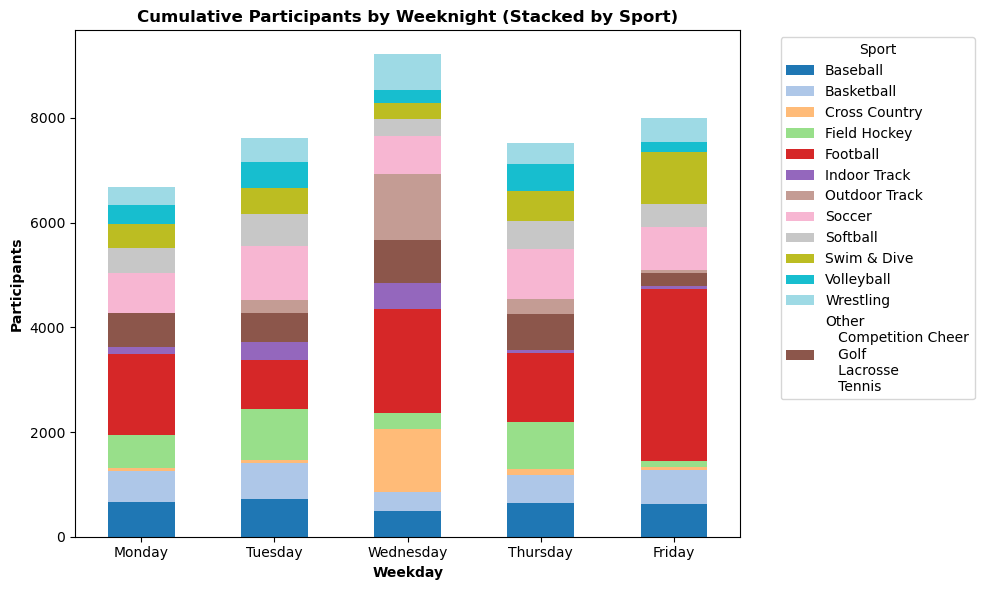

In [133]:

# --- 1) Aggregate by Weekday + Sport ---
agg = (
    SAN_df.groupby(['Weekday','Sport'])['Participants']
    .sum()
    .reset_index()
)

# --- 2) Compute total participants per sport (across all weekdays) ---
sport_totals = agg.groupby('Sport')['Participants'].sum()

# Decide threshold: sports with less than 3.5% of total go into "Other"
threshold = 0.035 * sport_totals.sum()
small_sports = sport_totals[sport_totals < threshold].index.tolist()

# --- 3) Relabel small sports as "Other" ---
agg['Sport'] = agg['Sport'].replace(small_sports, "Other")

# --- 4) Pivot to wide format (Weekday rows, Sport columns) ---
pivot = agg.groupby(['Weekday','Sport'])['Participants'].sum().unstack(fill_value=0)

# Reindex to keep weekdays in order
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday"]
pivot = pivot.reindex(weekday_order)

# --- 5) Plot stacked bar chart ---
ax = pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(10,6),
    colormap="tab20"
)

plt.title("Cumulative Participants by Weeknight (Stacked by Sport)", fontweight='bold')
plt.xlabel("Weekday", fontweight='bold')
plt.ylabel("Participants", fontweight='bold')
plt.xticks(rotation=0)

# --- 6) Customize legend ---
handles, labels = ax.get_legend_handles_labels()

# Move "Other" to the end
if "Other" in labels:
    idx = labels.index("Other")
    # Pop handle + label
    other_handle = handles.pop(idx)
    other_label = labels.pop(idx)
    # Create a custom label with sub-sports listed
    other_sublabels = "\n   " + "\n   ".join(small_sports)
    new_label = f"{other_label}{other_sublabels}"
    # Append back at end
    handles.append(other_handle)
    labels.append(new_label)

plt.legend(handles, labels, title="Sport", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [135]:

# 1) Daily totals per sport across all schools (only Tue/Wed/Thu)
midweek = SAN_df.copy()
midweek['EventDate'] = pd.to_datetime(midweek['Date'], errors='coerce')
midweek['Weekday'] = midweek['EventDate'].dt.day_name()
midweek = midweek[midweek['Weekday'].isin(['Tuesday','Wednesday','Thursday'])]

daily_sport_totals = (
    midweek.groupby(['EventDate','Weekday','Sport'], as_index=False)['Participants'].sum()
)

# 2) Build full Tue/Wed/Thu calendar over your study window
start = daily_sport_totals['EventDate'].min()
end   = daily_sport_totals['EventDate'].max()
cal = pd.DataFrame({'EventDate': pd.date_range(start, end, freq='D')})
cal['Weekday'] = cal['EventDate'].dt.day_name()
cal = cal[cal['Weekday'].isin(['Tuesday','Wednesday','Thursday'])]

# 3) Cross-join calendar with all sports
sports = pd.DataFrame({'Sport': sorted(midweek['Sport'].unique())})
cal_all = cal.merge(sports, how='cross')

# 4) Left-join totals; fill missing with 0 for no-event days
cal_filled = cal_all.merge(daily_sport_totals,
                           on=['EventDate','Weekday','Sport'],
                           how='left')
cal_filled['Participants'] = cal_filled['Participants'].fillna(0)

# 5) Average INCLUDING zero-event days
avg_by_weekday_sport_incl_zeros = (
    cal_filled.groupby(['Weekday','Sport'], as_index=False)['Participants']
              .mean()
              .rename(columns={'Participants':'AvgParticipants'})
)

avg_by_weekday_sport_incl_zeros

,Weekday,Sport,AvgParticipants
0,Thursday,Baseball,14.727273
1,Thursday,Basketball,12.272727
2,Thursday,Competition Cheer,0.409091
3,Thursday,Cross Country,2.272727
4,Thursday,Field Hockey,20.500000
5,Thursday,Football,30.000000
6,Thursday,Golf,2.954545
7,Thursday,Indoor Track,1.136364
8,Thursday,Lacrosse,5.454545
9,Thursday,Outdoor Track,6.818182


In [137]:
# Total busy students per weeknight (summing across all sports)
avg_students_weeknight = (
    avg_by_weekday_sport_incl_zeros
        .groupby('Weekday', as_index=False)['AvgParticipants']
        .sum()
        .rename(columns={'AvgParticipants':'AvgBusyStudents'})
        .sort_values('AvgBusyStudents', ascending=False)
)

print(avg_students_weeknight)


     Weekday  AvgBusyStudents
2  Wednesday       214.279070
1    Tuesday       177.186047
0   Thursday       171.090909


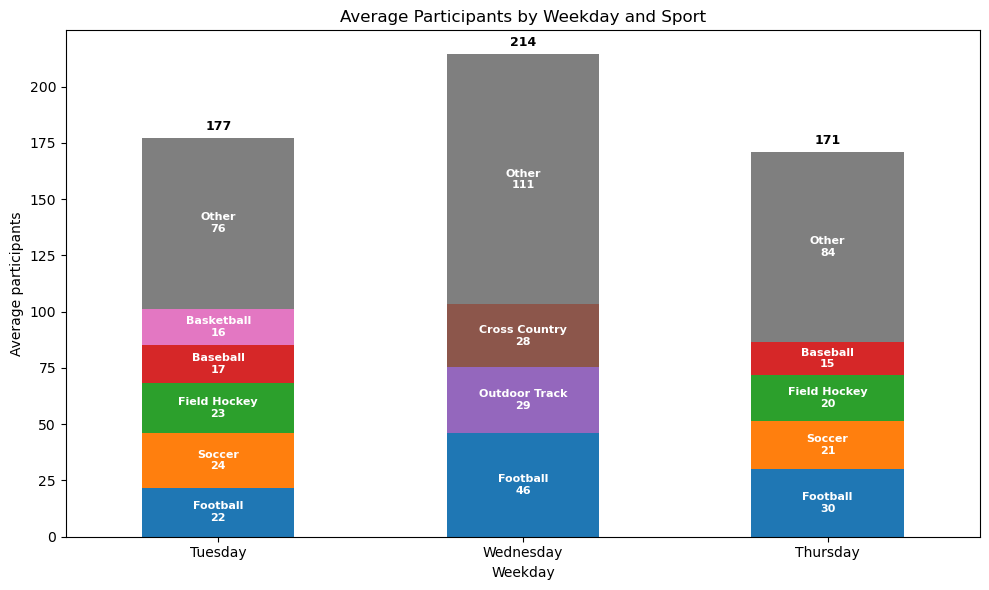

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- If your column names differ, set them here ---
COL_WEEKDAY = "Weekday"
COL_SPORT = "Sport"
COL_AVG = "AvgParticipants"

# Weekdays to plot & their order
weekdays_to_plot = ["Tuesday", "Wednesday", "Thursday"]

df0 = avg_by_weekday_sport_incl_zeros.copy()

# Keep only Tue/Wed/Thu and enforce order on x-axis
df = df0[df0[COL_WEEKDAY].isin(weekdays_to_plot)].copy()
df[COL_WEEKDAY] = pd.Categorical(df[COL_WEEKDAY], categories=weekdays_to_plot, ordered=True)

# Total per weekday
totals = df.groupby(COL_WEEKDAY, observed=True)[COL_AVG].sum().rename("Total").reset_index()
df = df.merge(totals, on=COL_WEEKDAY, how="left")
df["Share"] = np.where(df["Total"] > 0, df[COL_AVG] / df["Total"], 0.0)

# Group sub-8% sports into "Other" (per weekday)
df["SportGrouped"] = np.where(df["Share"] < 0.08, "Other", df[COL_SPORT])

# Aggregate after grouping
dfg = (df.groupby([COL_WEEKDAY, "SportGrouped"], observed=True, as_index=False)[COL_AVG]
         .sum())

# Pivot for stacked bars (rows=weekday on x-axis, columns=sports)
piv = dfg.pivot(index=COL_WEEKDAY, columns="SportGrouped", values=COL_AVG).fillna(0)

# Order columns by overall contribution, keep "Other" last
col_totals = piv.sum(axis=0).sort_values(ascending=False)
cols_order = [c for c in col_totals.index if c != "Other"] + (["Other"] if "Other" in col_totals.index else [])
piv = piv[cols_order].sort_index()  # Tue/Wed/Thu order

# --- Plot: vertical stacked bars (Weekday on x-axis, AvgParticipants on y-axis) ---
fig, ax = plt.subplots(figsize=(10, 6))
piv.plot(kind="bar", stacked=True, ax=ax)

ax.set_xlabel("Weekday")
ax.set_ylabel("Average participants")
ax.set_title("Average Participants by Weekday and Sport")

# --- Internal labels: Sport + value inside each stacked segment ---
min_pct_height = 0.06  # label only if segment ≥6% of y-axis span (avoid clutter)

ax.figure.canvas.draw()  # ensure limits exist
ymax = ax.get_ylim()[1]

for container in ax.containers:             # one container per sport (legend entry)
    sport_label = container.get_label()
    for rect in container.patches:          # each stacked segment is a rectangle
        height = rect.get_height()
        if height <= 0:
            continue
        if height >= min_pct_height * ymax:
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + height / 2
            label = f"{sport_label}\n{height:.0f}"
            ax.text(
                x, y, label,
                ha="center", va="center",
                color="white", fontsize=8, fontweight="bold"
            )

# --- Totals above each bar ---
totals_for_labels = piv.sum(axis=1)  # per weekday
for i, total in enumerate(totals_for_labels):
    ax.text(
        i, total + ymax * 0.01,
        f"{int(round(total))}",
        ha="center", va="bottom", fontsize=9, fontweight="bold"
    )
# Make weekday labels horizontal
ax.set_xticklabels(piv.index, rotation=0)
# Optional: keep legend or rely on internal labels only
# leg = ax.legend(title="Sport", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
ax.legend_.remove()  # comment this line if you want the legend

plt.tight_layout()
plt.show()
